# Libraries, Constants and Dataframe

In [1]:
import pandas as pd 
import numpy as np

import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
import spacy
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
REVIEW = "Review"
LIKED = "Liked"

BIGRAM = "bigram"
TRIGRAM = "trigram"
CORPUS = "corpus"
ID_TO_WORD = "id_to_word"
PERPLEXITY = "perplexity"
COHERENCE = "coherence"

In [3]:
df_raw_comments = pd.read_csv("../resources/Restaurant_Reviews.tsv", sep='\t')
df_raw_comments.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


# Data Preprocessing 

In [4]:
def plot_word_cloud(df: pd.DataFrame, nb_words: int) -> None:
    long_string = ','.join(list(df[REVIEW].values)) # Group all comments in 1 string
    wordcloud = WordCloud(background_color="white", max_words=nb_words, contour_width=3, contour_color='steelblue')
    wordcloud.generate(long_string)
    return wordcloud.to_image()

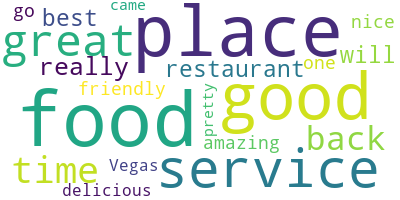

In [5]:
plot_word_cloud(df_raw_comments, 20)

In [6]:
def sentence_to_words(sentences: list) -> object:
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
list_of_every_words = list(sentence_to_words(df_raw_comments.values.tolist()))
list_of_every_words[:3]

[['wow', 'loved', 'this', 'place'],
 ['crust', 'is', 'not', 'good'],
 ['not', 'tasty', 'and', 'the', 'texture', 'was', 'just', 'nasty']]

In [8]:
def build_bigram_and_trigram(words_list: list) -> dict:
    bigram = gensim.models.Phrases(words_list, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[words_list], threshold=100)
    
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return {BIGRAM: bigram_mod, TRIGRAM: trigram_mod}

In [9]:
bigram_and_trigram = build_bigram_and_trigram(list_of_every_words)

In [10]:
def remove_stopwords(texts: list) -> list:
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
    
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [11]:
list_of_words_no_stops = remove_stopwords(list_of_every_words)

In [12]:
def make_bigrams(texts: list) -> list:
    bigram_mod = bigram_and_trigram[BIGRAM]
    return [bigram_mod[doc] for doc in texts]

In [13]:
data_words_bigrams = make_bigrams(list_of_words_no_stops)

In [14]:
def make_trigrams(texts: list) -> list:
    trigram_mod = bigram_and_trigram[TRIGRAM]
    bigram_mod = bigram_and_trigram[BIGRAM]
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [15]:
data_words_trigrams = make_trigrams(list_of_words_no_stops)

In [16]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
# Use either                    data_words_bigrams or data_words_trigrams

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized[:5]

[['love', 'place'],
 ['crust', 'good'],
 ['tasty', 'texture', 'nasty'],
 ['stop',
  'late',
  'may',
  'bank',
  'holiday',
  'rick',
  'steve',
  'recommendation',
  'love'],
 ['selection', 'menu', 'great', 'price']]

# Create the Dictionary and Corpus needed for Topic Modeling

In [18]:
def _create_word_id(words_lemmatized: list) -> dict:
    id_to_word = corpora.Dictionary(words_lemmatized)
    corpus = [id_to_word.doc2bow(text) for text in words_lemmatized]
    return {CORPUS: corpus, ID_TO_WORD: id_to_word}

In [19]:
dict_and_corpus = _create_word_id(data_lemmatized)
# dict_and_corpus

In [20]:
def compute_term_frequency_in_sentence(words_lemmatized: list):
    id2word = dict_and_corpus[ID_TO_WORD]
    corpus = dict_and_corpus[CORPUS]
    
    return [[(id2word[id], freq) for id, freq in cp] for cp in corpus]

In [21]:
# compute_term_frequency_in_sentence(data_lemmatized)

# Modeling

### Basic LDA model

In [22]:
def build_lda_model(nb_topics):
    corpus = dict_and_corpus[CORPUS]
    id2word = dict_and_corpus[ID_TO_WORD]
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=nb_topics, 
                                                random_state=100, update_every=1, chunksize=100, passes=10, 
                                                alpha='auto', per_word_topics=True)
    
    return lda_model

In [23]:
# Get the 10 most used keywords per topic
model_lda = build_lda_model(10)
# model_lda.print_topics()

In [24]:
def compute_lda_model_score(words_lemmatized: list):
    corpus = dict_and_corpus[CORPUS]
    id2word = dict_and_corpus[ID_TO_WORD]
    
    coherence_model_lda = CoherenceModel(model=model_lda, texts=words_lemmatized, dictionary=id2word, coherence='c_v')
    
    perplexity_score = model_lda.log_perplexity(corpus)
    coherence_score = coherence_model_lda.get_coherence()
    
    return {PERPLEXITY: perplexity_score, COHERENCE: coherence_score}

In [25]:
def visualize_topic_keywords(words_lemmatized: list, model) -> None:
    corpus = dict_and_corpus[CORPUS]
    id2word = dict_and_corpus[ID_TO_WORD]

    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim.prepare(model, corpus, id2word)

In [26]:
visualize_topic_keywords(data_lemmatized, model_lda)

/Users/nicolasrousseau/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.258334  0.021623       1        1  15.241941
8      0.146925 -0.158978       2        1  13.776138
0      0.034796  0.287590       3        1  12.310122
6      0.052625  0.025817       4        1  10.116257
4     -0.010161 -0.134598       5        1   9.817778
3     -0.133188 -0.021092       6        1   9.041381
9     -0.097661 -0.000382       7        1   8.325490
2     -0.058431  0.006742       8        1   8.002327
5     -0.096310 -0.006010       9        1   6.759788
7     -0.096929 -0.020710      10        1   6.608775, topic_info=    Category        Freq     Term       Total  loglift  logprob
79   Default  113.000000     food  113.000000  30.0000  30.0000
1    Default   99.000000    place   99.000000  29.0000  29.0000
39   Default   73.000000  service   73.000000  28.0000  28.0000
3    Default   89.000000     good   89.000000  27.0000  27.0000
40   Default   45.000000     back   45.000000  26.0000  26.0000
..       ...         ...      ...         ...      ...      ...
702  Topic10    1.996814      sub    2.689638   2.4189  -5.1567
281  Topic10    1.826904    guess    2.519772   2.3952  -5.2456
95   Topic10    6.857105    salad   11.151504   2.2305  -3.9230
41   Topic10    7.801158       go   59.522766   0.6847  -3.7940
984  Topic10    3.146271      dry    8.065762   1.7754  -4.7020

[350 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
213       4  0.902559  absolutely
80        8  0.958913        also
253       3  0.900993      always
78        8  0.969949     amazing
422       3  0.932440    ambiance
...     ...       ...         ...
705       7  0.757294        work
75        2  0.970880       worth
42        6  0.966835       would
734       9  0.664957       wrong
324       5  0.775593       yummy

[328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 1, 7, 5, 4, 10, 3, 6, 8])

### LDA Mallet model

In [27]:
def build_lda_mallet_model(words_lemmatized):
    corpus = dict_and_corpus[CORPUS]
    id2word = dict_and_corpus[ID_TO_WORD]

    mallet_path = "../resources/mallet-2.0.8/bin/mallet"
    return gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [28]:
lda_mallet_model = build_lda_mallet_model(data_lemmatized)

In [29]:
def compute_lda_mallet_coherence(words_lemmatized: list):
    id2word = _create_word_id(words_lemmatized)[ID_TO_WORD]
    corpus = dict_and_corpus[CORPUS]
    
    coherence_model_lda_mallet = CoherenceModel(model=lda_mallet_model, texts=words_lemmatized, 
                                                dictionary=id2word, coherence='c_v')
    
    coherence_lda_mallet = coherence_model_lda_mallet.get_coherence()
    perplexity_score = model_lda.log_perplexity(corpus)
    
    return {PERPLEXITY: perplexity_score, COHERENCE: coherence_lda_mallet}

### Compare models results

In [30]:
# Basic LDA model : 10 main topics with 10 most important words
pprint(model_lda.show_topics(formatted=True))

[(0,
  '0.113*"service" + 0.079*"great" + 0.052*"come" + 0.031*"feel" + '
  '0.025*"server" + 0.023*"pizza" + 0.018*"table" + 0.016*"always" + '
  '0.014*"owner" + 0.013*"check"'),
 (1,
  '0.141*"food" + 0.108*"good" + 0.027*"make" + 0.021*"time" + 0.017*"bad" + '
  '0.017*"flavor" + 0.016*"love" + 0.016*"menu" + 0.016*"terrible" + '
  '0.016*"could"'),
 (2,
  '0.046*"also" + 0.042*"pretty" + 0.040*"amazing" + 0.035*"taste" + '
  '0.030*"star" + 0.029*"awesome" + 0.024*"fresh" + 0.021*"give" + '
  '0.020*"disappointed" + 0.019*"overprice"'),
 (3,
  '0.095*"back" + 0.094*"go" + 0.055*"would" + 0.042*"really" + '
  '0.021*"recommend" + 0.021*"hot" + 0.019*"enough" + 0.019*"slow" + '
  '0.018*"little" + 0.016*"disappoint"'),
 (4,
  '0.051*"eat" + 0.043*"wait" + 0.043*"say" + 0.029*"want" + 0.029*"well" + '
  '0.026*"way" + 0.025*"dish" + 0.024*"try" + 0.017*"night" + '
  '0.016*"everything"'),
 (5,
  '0.050*"restaurant" + 0.038*"chicken" + 0.037*"meal" + 0.025*"thing" + '
  '0.022*"meat" 

In [31]:
# LDA Mallet model : 10 main topics with 10 most important words
pprint(lda_mallet_model.show_topics(formatted=True))

[(0,
  '0.074*"bad" + 0.041*"salad" + 0.033*"quality" + 0.029*"night" + '
  '0.026*"burger" + 0.024*"worth" + 0.022*"beer" + 0.022*"friend" + '
  '0.019*"rude" + 0.014*"small"'),
 (1,
  '0.177*"great" + 0.052*"amazing" + 0.045*"pizza" + 0.042*"delicious" + '
  '0.025*"meat" + 0.022*"spicy" + 0.020*"waste" + 0.017*"ambiance" + '
  '0.017*"fantastic" + 0.015*"authentic"'),
 (2,
  '0.260*"food" + 0.036*"dish" + 0.030*"fresh" + 0.026*"selection" + '
  '0.024*"atmosphere" + 0.021*"disappointed" + 0.019*"day" + 0.017*"hour" + '
  '0.015*"people" + 0.015*"stay"'),
 (3,
  '0.265*"place" + 0.071*"eat" + 0.043*"vegas" + 0.043*"pretty" + '
  '0.031*"thing" + 0.028*"bland" + 0.017*"nice" + 0.017*"attentive" + '
  '0.012*"drive" + 0.012*"town"'),
 (4,
  '0.144*"back" + 0.067*"wait" + 0.048*"price" + 0.045*"minute" + 0.043*"make" '
  '+ 0.033*"table" + 0.024*"lunch" + 0.022*"spot" + 0.019*"breakfast" + '
  '0.019*"happy"'),
 (5,
  '0.196*"service" + 0.043*"steak" + 0.031*"sushi" + 0.029*"serve" + '


In [32]:
basic_lda = compute_lda_model_score(data_lemmatized)
lda_mallet = compute_lda_mallet_coherence(data_lemmatized)

dict_models = {PERPLEXITY: "perplexity", COHERENCE: "coherence"}
dict_scoring_basic_lda = {PERPLEXITY: basic_lda[PERPLEXITY], COHERENCE: basic_lda[COHERENCE]}
dict_scoring_mallet_lda = {PERPLEXITY: lda_mallet[PERPLEXITY], COHERENCE: lda_mallet[COHERENCE]}

In [33]:
def display_scoring_results(dict_score: dict, dict_eval_basic: dict, dict_eval_mallet: dict) -> pd.DataFrame:
    list_scoring_name = []
    list_scoring_basic = []
    list_scoring_mallet = []
    
    for scoring in dict_score.keys():
        list_scoring_name.append(dict_score[scoring])
        list_scoring_basic.append(dict_eval_basic[scoring])
        list_scoring_mallet.append(dict_eval_mallet[scoring])
    
    return pd.DataFrame({"Scoring": list_scoring_name, "LDA Basic": list_scoring_basic, "LDA Mallet": list_scoring_mallet}
                       ).set_index("Scoring")

In [34]:
display_scoring_results(dict_models, dict_scoring_basic_lda, dict_scoring_mallet_lda)

,LDA Basic,LDA Mallet
Scoring,,
perplexity,-7.464506,-7.464506
coherence,0.591759,0.705292


### Find optimal number of topics

In [35]:
def compute_coherence_values(words_lemmatized: list, limit_max: int):
    corpus = dict_and_corpus[CORPUS]
    id2word = dict_and_corpus[ID_TO_WORD]
    mallet_path = "../resources/mallet-2.0.8/bin/mallet"
    start = 1
    step = 1
    limit = limit_max
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=limit_max, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=words_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:
%%time
model_list, coherence_values = compute_coherence_values(data_lemmatized, 10)

CPU times: user 4.13 s, sys: 292 ms, total: 4.42 s
Wall time: 12min 43s


In [37]:
def plot_coherence_score_per_nb_of_topics(limit_max: int):
    limit=limit_max
    start=1
    step=1
    
    x = range(start, limit, step)
    plt.figure(figsize=(14, 8))
    plt.plot(x, coherence_values)
    plt.xlabel("Number of topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    
    for m, cv in zip(x, coherence_values):
        print(f"Nb of topics = {m} -> Associated coherence value = {round(cv, 4)}")
    
    return plt.show()

Nb of topics = 1 -> Associated coherence value = 0.6992
Nb of topics = 2 -> Associated coherence value = 0.6976
Nb of topics = 3 -> Associated coherence value = 0.6951
Nb of topics = 4 -> Associated coherence value = 0.7072
Nb of topics = 5 -> Associated coherence value = 0.6967
Nb of topics = 6 -> Associated coherence value = 0.6977
Nb of topics = 7 -> Associated coherence value = 0.7158
Nb of topics = 8 -> Associated coherence value = 0.7085
Nb of topics = 9 -> Associated coherence value = 0.7005


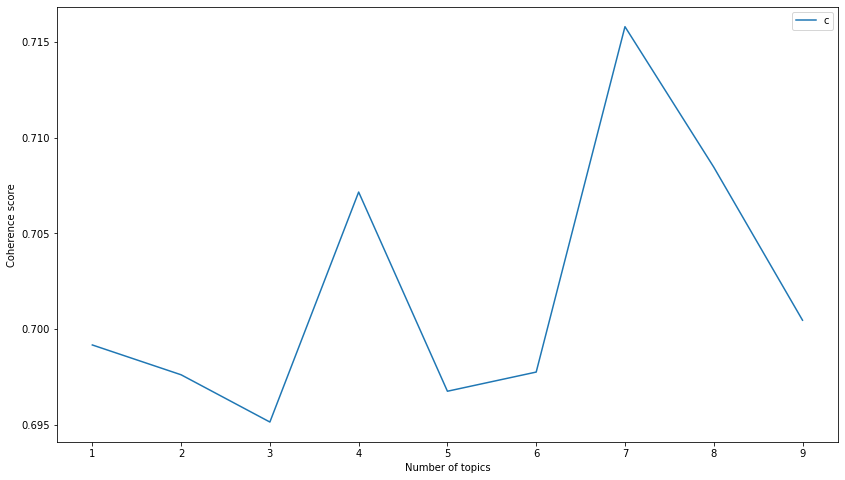

In [38]:
plot_coherence_score_per_nb_of_topics(10)

Since the coherence score doesn't vary that much (between 0.695 and 0.715) I decide to select 10 as the optimal number of topics because I chose this number on the previous notebook

In [39]:
optimal_model = model_list[-1]
optimal_model.show_topics(formatted=False)

[(0,
  [('wait', 0.07493540051679587),
   ('order', 0.07235142118863049),
   ('minute', 0.04909560723514212),
   ('pizza', 0.028423772609819122),
   ('beer', 0.023255813953488372),
   ('seat', 0.023255813953488372),
   ('day', 0.023255813953488372),
   ('absolutely', 0.020671834625323),
   ('deal', 0.01808785529715762),
   ('authentic', 0.015503875968992248)]),
 (1,
  [('service', 0.19489559164733178),
   ('restaurant', 0.06496519721577726),
   ('taste', 0.048723897911832945),
   ('dish', 0.037122969837587005),
   ('fresh', 0.03248259860788863),
   ('thing', 0.030162412993039442),
   ('awesome', 0.027842227378190254),
   ('lunch', 0.02320185614849188),
   ('amazing', 0.02088167053364269),
   ('rude', 0.018561484918793503)]),
 (2,
  [('back', 0.14388489208633093),
   ('pretty', 0.047961630695443645),
   ('star', 0.04316546762589928),
   ('give', 0.03597122302158273),
   ('bland', 0.02877697841726619),
   ('quality', 0.02877697841726619),
   ('leave', 0.026378896882494004),
   ('breakfas

In [40]:
def format_topics_sentences(ldamodel, words_lemmatized: list) -> pd.DataFrame:
    # Init output
    sent_topics_df = pd.DataFrame()
    corpus = dict_and_corpus[CORPUS]
    texts = df_raw_comments.values.tolist() #list_of_every_words

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['dominant_topic_LDA', 'percentage_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.reset_index()
    sent_topics_df.columns = ['dominant_topic_LDA', 'topic_percentage_contribution', 'keywords_LDA', 'text']
    
    # Split REVIEW and LIKED variables
    sent_topics_df[[REVIEW,LIKED]] = pd.DataFrame(sent_topics_df["text"].tolist())
    sent_topics_df.drop(columns=["text"], inplace=True)
    
    return sent_topics_df

In [41]:
df_topic_sents_keywords = format_topics_sentences(optimal_model, data_lemmatized)
df_topic_sents_keywords

,dominant_topic_LDA,topic_percentage_contribution,keywords_LDA,Review,Liked
0,5.0,0.1154,"place, vegas, recommend, terrible, selection, ...",Wow... Loved this place.,1
1,3.0,0.1282,"good, burger, fantastic, enjoy, sauce, atmosph...",Crust is not good.,0
2,6.0,0.1153,"eat, make, feel, server, serve, sandwich, slow...",Not tasty and the texture was just nasty.,0
3,5.0,0.1398,"place, vegas, recommend, terrible, selection, ...",Stopped by during the late May bank holiday of...,1
4,9.0,0.1296,"great, friendly, staff, fry, menu, disappointe...",The selection on the menu was great and so wer...,1
...,...,...,...,...,...
995,7.0,0.1502,"love, chicken, amazing, flavor, table, buffet,...",I think food should have flavor and texture an...,0
996,4.0,0.1154,"time, experience, price, steak, night, excelle...",Appetite instantly gone.,0
997,2.0,0.1346,"back, pretty, star, give, bland, quality, leav...",Overall I was not impressed and would not go b...,0
998,4.0,0.1253,"time, experience, price, steak, night, excelle...","The whole experience was underwhelming, and I ...",0


In [42]:
# df_topic_sents_keywords.to_csv("../resources/df_cluster_LDA.csv", index=False, sep="," , encoding="utf-8")